In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

# Cutting 

from cut_audio import *

%matplotlib inline

In [2]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_raw_10_1028_20.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         1  ../Project/data/train/audio/bed/26e9ae6b_nohas...  26e9ae6b  bed   
1         0  ../Project/data/train/audio/bed/c1eebc0b_nohas...  c1eebc0b  bed   
2         0  ../Project/data/train/audio/bed/888a0c49_nohas...  888a0c49  bed   
3         0  ../Project/data/train/audio/bed/413997c1_nohas...  413997c1  bed   
4         1  ../Project/data/train/audio/bed/2be08ce4_nohas...  2be08ce4  bed   

      mfcc                                                ...              \
  raw_mfcc                                                ...               
         0        1        2        3        4        5   ...         190   
0 -792.254   -787.7 -791.539 -789.665 -654.321 -601.683   ...     8.70598   
1 -489.317 -281.411 -153.447 -96.2069 -85.2913 -99.3898   ...     21.8332   
2 -551.097 -514.938 -492.838 -486.028 -497.269 -272.339   ...     9.25921   
3 -561.107 -313.113  -226.13 -243.191 -254.779 -258.498   ...     21.6845   
4 -471.951 -397.382 -295.359 -241.427 -219.029 -215.649   ...     35.6558   

                                                                              \
                                                                               
       191       192       193      194      195      196       197      198   
0  2.59404  0.659452   5.04189  2.56198  13.0749  8.08766   14.1877  24.2039   
1  19.6169   17.4731   15.8701   14.147  11.3736  8.31899 -0.998932 -6.97295   
2   12.553   9.90252   15.5926  10.9931  10.1983  11.9801   15.2197  7.28049   
3  22.4279   21.6987 -0.481375 -5.69828 -1.02575 -1.86343   2.16876 -1.24089   
4  33.4182   35.1405   36.9393  35.4168  30.4814  26.2262   22.3652  20.4492   

            
            
       199  
0  18.5999  
1 -4.75059  
2 -5.99168  
3 -7.62565  
4  21.4971  

[5 rows x 204 columns]

### Split data in batches :

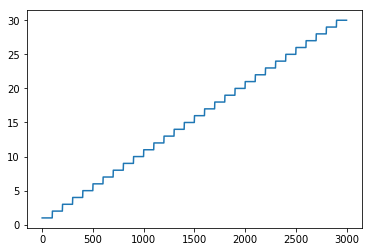

In [31]:
# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
label_vec = np.ones(len(features_og))
for i in range(0,len(class_names)):
    label_vec +=(features_og['info','word'] == class_names[i]) * i
    
label_vec.plot()

In [32]:
n_classes = len(class_names)
n_samples = len(features_og)

k_fold = 5

batch_size = int(n_samples / k_fold)
class_size = int(batch_size / n_classes)
                 
batch_idx = np.zeros((k_fold, batch_size))

In [33]:
for i in range(n_classes):
    class_index = np.where(label_vec == (i+1))[0]
    random_index = np.reshape(np.random.choice(range(len(class_index)), size=class_size*k_fold, replace=False), 
                              (k_fold, class_size))
    
    batch_idx[:,class_size * i: class_size*(i+1)] = class_index[random_index]
    

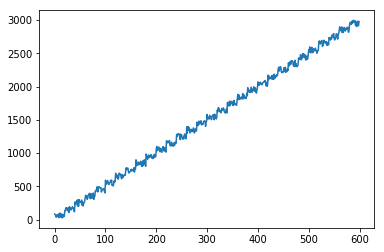

In [34]:
plt.plot(batch_idx[0,:])

### Spectral clustering :

In [125]:
accuracy = []

for k in tqdm(range(k_fold)):
    features = pd.DataFrame(features_og['mfcc'].iloc[batch_idx[k][:].astype(int)])
    features -= features.mean(axis=0)
    features /= features.std(axis=0)
    
    # keep mapping from batch id to main id
    id_mapping = dict(zip(features.index, range(len(features))))
    
    distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))
    
    n=distances.shape[0]
    kernel_width = distances.mean()
    weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
    np.fill_diagonal(weights,0)
    
    NEIGHBORS = 600

    for i in range(weights.shape[0]):
        idx = weights[i,:].argsort()[:-NEIGHBORS]
        weights[i,idx] = 0
        weights[idx,i] = 0
        
    degrees = np.sum(weights,axis=0)
    laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
    laplacian = sparse.csr_matrix(laplacian)

    eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=25,which='SM')
        
    # get training and testing features
    ml_index = np.reshape(batch_idx[k,:], (-1, class_size))
    train_index = np.reshape(ml_index[:,:int(0.8*class_size)].astype(int), (1,-1))
    test_index = np.reshape(ml_index[:,int(0.8*class_size):].astype(int), (1,-1))

    train_index = [id_mapping[i] for i in train_index[0]]
    test_index = [id_mapping[i] for i in test_index[0]]

    # get features
    train_features = eigenvectors[train_index,:]
    test_features = eigenvectors[test_index,:]
    train_y = label_vec[train_index]
    test_y = label_vec[test_index]
    
    # ML
    clf  = GaussianNB()
    clf.fit(train_features, train_y)
    predict_y = clf.predict(test_features)
    accuracy.append(np.sum(test_y==predict_y)/len(test_y))
    

100%|████████████████████████████████████████████| 5/5 [00:01<00:00,  2.63it/s]


In [126]:
accuracy

[0.5,
 0.54166666666666663,
 0.53333333333333333,
 0.55833333333333335,
 0.5083333333333333]